<div class="green">
    
# <span style="color:green">Consumer Complaint Response</span>
    
#### <span style="color:lightgreen">GitHubs: [Tyler Kephart](https://github.com/tkephart96) | [Chellyan Moreno](https://github.com/chellyan-moreno) | [Rosendo Lugo](https://github.com/rosendo-lugo) | [Alexia Lewis](https://github.com/lewisalexia)</span>
   
</div>

<div class="alert alert-success">    
    
## Goal: 
This classification NLP project aims to provide an accurate prediction of company response based on the language of a consumer's complaint.

## Description:

Our project involves analyzing 3.5 million consumer complaints to the Consumer Financial Protection Bureau (CFPB) from 2011 to 2023. We'll use Natural language Processing to analyze how the wording of complaints affects a company's response. Our goal is to provide insights on complaint language and its impact, helping companies improve their responses and enhancing the outcomes for consumers and businesses.
  
</div>

# <span style="color:green">Imports</span>
    

In [1]:
#local modules
import wrangle as wr
import explore as ex
import model as mo

#standard
import pandas as pd

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_colwidth", 250)

imports loaded successfully, awaiting commands...


# <span style="color:green">Wrangle</span>

---

* <span style="color:green">Data acquired from [Google BigQuery](https://console.cloud.google.com/marketplace/product/cfpb/complaint-database)
* <span style="color:green">3,458,906 rows × 18 columns *before* cleaning
* <span style="color:green">1,238,536 rows x 7 columns *after* cleaning</span>


### <span style="color:lightgreen">Data Dictionary</span>

<details>
  <summary>Show Data Dictionary</summary>

| Feature                               | Definition                                                                                  |
| :------------------------------------ | :------------------------------------------------------------------------------------------ |
| date_received                         | Date the complaint was received by the CFPB                                                 |
| product                               | The type of product the consumer identified in the complaint                                |
| subproduct                            | The type of sub-product the consumer identified in the complaint                            |
| issue                                 | The issue the consumer identified in the complaint                                          |
| subissue                              | The sub-issue the consumer identified in the complaint                                      |
| consumer_complaint_narrative          | A description of the complaint provided by the consumer                                     |
| company_public_response               | The company's optional public-facing response to a consumer's complaint                     |
| company_name                          | Name of the company identified in the complaint by the consumer                             |
| state                                 | Two-letter postal abbreviation of the state of the mailing address provided by the consumer |
| zip_code                              | The mailing ZIP code provided by the consumer                                               |
| tags                                  | Older American is aged 62 and older, Servicemember is Active/Guard/Reserve member or spouse |
| consumer_consent_provided             | Identifies whether the consumer opted in to publish their complaint narrative               |
| submitted_via                         | How the complaint was submitted to the CFPB                                                 |
| date_sent_to_company                  | The date the CFPB sent the complaint to the company                                         |
| company_response_to_consumer (target) | The response from the company about this complaint                                          |
| timely_response                       | Indicates whether the company gave a timely response or not                                 |
| consumer_disputed                     | Whether the consumer disputed the company's response                                        |
| complaint_id                          | Unique ID for complaints registered with the CFPB                                           |
| product_bins                          | Engineered Feature: bin related products together                                           |
| clean                                 | Engineered Feature: tokenized, numbers/specials, and XX's removed                           |
| lemon                                 | Engineered Feature: clean column PLUS lemmatization                                         |
| response                              | Engineered Feature: binned company responses to relief and no relief                        |

</details>

# <span style="color:green">Prepare</span>  
---

* <span style="color:green">Clean the data
  * Drop columns
  * Rename columns
  * Remove nulls
  * Fixed data type
* <span style="color:green">Create engineered columns from existing data
  * Bin products
  * Bin company responses
  * Process narrative into lemon
* <span style="color:green">Encode categorical columns
* <span style="color:green">Split data (60/20/20)</span>


<div class="alert alert-block alert-warning">

### **NOTE**: This is a new iteration, delete any parquet file and run again

</div>

In [2]:
# Acquire and write/read CSV
# Clean and NLTK prepare
# relatively quicker 20+ min
df = wr.wrangle_complaints()

# longer run 50+ min
# df = wr.wrangle_complaints_the_long_way()

# bin responses to relief and no relief
df = wr.prep_response(df)

parquet file found and loaded


<div class="alert alert-success">    

### Insight:
    
Used NLTK to clean each document resulting in:
* 2 new columns: *lemon* (lemmatized, only real words, no stopwords) and *response* (binned company responses)

Selected columns to proceed with after cleaning:
* date_received, product_bins, company_name, state, tags, lemon, response (target)
    
</div>

# <span style="color:green">Explore</span>
    
---


### <span style="color:lightgreen">Split</span>

In [3]:
# Split
train, validate, test = wr.split_data(df,"response")

Prepared DF: (1238536, 7)
Train: (743121, 7)
Validate: (247707, 7)
Test: (247708, 7)


<div class="alert alert-success">  

## <span style="color:darkgreen">Questions To Answer:</span>

**1. Are there words that get particular responses and is there a relationship?**
* What are the payout words that got relief from the company?

**2. Do all responses have a negative sentiment?**
* Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to relief from the company?

**3. Are there unique words associated with no relief from the company?**

**4. Which product is more likely to have relief?**
</div>

### <span style="color:lightblue">**1. Are there words that get particular company responses and is there a relationship?**</span>

Initial Thoughts:
* Separating each word by row and then do a frequency count of each word that appears in the lemon column
* Sample: Max features of 20,000
* Count Words: Use a CountVectorizer to count word appearances in each complaint
* Compare: Calculate the average count of each word for each response to see which words are used most often
* Visualize: Create a barplot to show which words are most associated with each response

In [4]:
# Calculates the word counts for each response type in the given training data  avg runtime 9 min
word_counts, df_with_words, word_counts_ones = ex.get_word_counts2(train)
# Retrieves the top 15 most frequently occurring words for each response type
ex.top_15_words2(word_counts_ones)

,credit,account,report,information,consumer,payment,time,would,debt,day,loan,bank,received,company,card
relief,180291,145662,89481,86386,52752,51507,51143,49463,46615,45479,42611,42557,40946,39732,38025
no_relief,609695,498824,303148,292674,175595,177663,172501,167623,157406,156484,146068,146676,137942,135478,128257


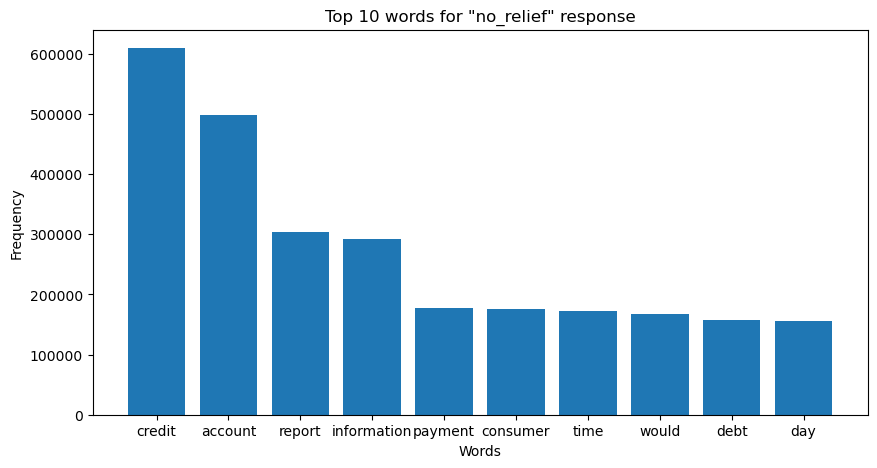

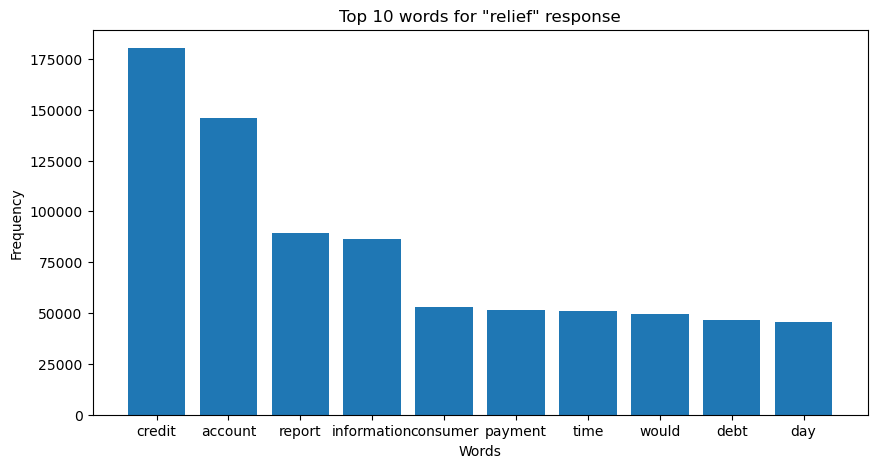

In [5]:
# Creates a bar plot to visualize the top 10 most frequently occurring words for each response type
ex.frequent_words_plot2(df_with_words,word_counts_ones)

<div class="alert alert-success">    

## Insight:
* Based on the top 15 words there are no specific words that are associated with a specific respond.   

* Common Words: 
    The most common words in all company responses are: 
    credit,
    account,
    report,
    information,
    consumer,
    payment,
    time,
    would,
    debt,
    and "day"     
* No Specific Words: 
    There are no specific complaint words that are only associated with a certain type of company response. This means consumers use similar language regardless of their response type. 
    
* Credit is Popular: 
    The word credit is the most frequently used word in company responses. This suggests that many complaints are related to issues with credit.  
    
* Response Types: 
    The response type "no_relief" has the highest word count for all the top words. This means that companies tend to respond with no relief more often. 


</div>

### <span style="color:lightblue">**2. Do all responses have a negative sentiment?**</span>
* <span style="color:lightblue">Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to relief from the company? </span>

$H_0$: There is no significant effect of sentiment on company response to the consumer.


$H_a$: There is a significant effect of sentiment on company response to the consumer.

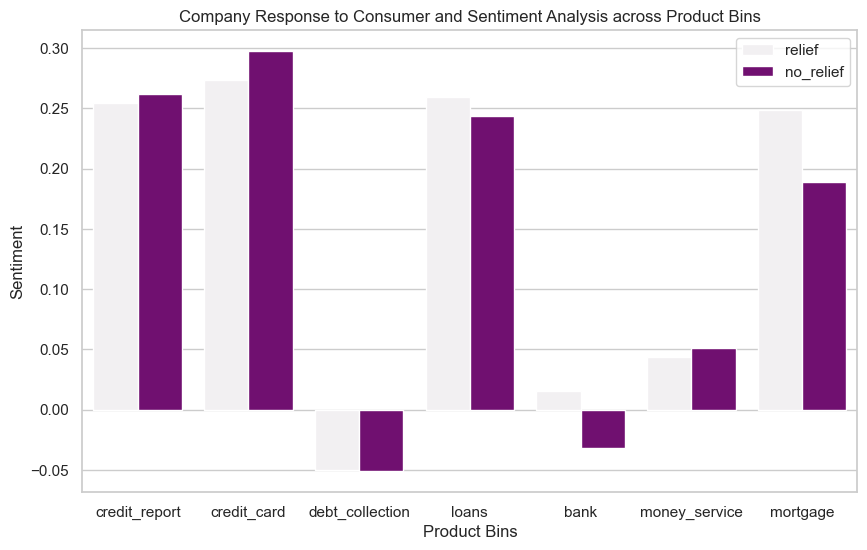

Running Levene Test...
p-value: 0.1361886976 > 0.05?

Variance is true, proceed with ANOVA test...

Product Bins: credit_report
ANOVA p-value: 0.0009416221127570565
Significant effect of sentiment on company response to the consumer.

Product Bins: credit_card
ANOVA p-value: 2.1675489725268552e-05
Significant effect of sentiment on company response to the consumer.

Product Bins: debt_collection
ANOVA p-value: 0.8663529289969345
No significant effect of sentiment on company response to the consumer.

Product Bins: loans
ANOVA p-value: 0.09276453839880877
No significant effect of sentiment on company response to the consumer.

Product Bins: bank
ANOVA p-value: 1.466054608691757e-11
Significant effect of sentiment on company response to the consumer.

Product Bins: money_service
ANOVA p-value: 0.528449611937943
No significant effect of sentiment on company response to the consumer.

Product Bins: mortgage
ANOVA p-value: 3.1456837275452693e-09
Significant effect of sentiment on company re

In [6]:
# visualize data and run statistical analysis   avg runtime 4 min
ex.analyze_sentiment2(train)

<div class="alert alert-success">    

### Insight: 
#### - Overall, there is not a strong correlation between the sentiment of consumer complaints and the corresponding responses from companies.

1. **Mortgage**:
  - Consumer complaints exhibit predominantly neutral to positive sentiment, and companies provide relief responses to slightly more positive sentiment.

2. **Credit Report**:
  - Consumer complaints with neutral to positive sentiment tend to receive an equal distribution of responses.

3. **Debt Collection**:
  - All consumer complaints have neutral to negative sentiment scores.

4. **Loans**:
  - Consumer complaints with neutral to positive sentiment tend to receive an equal distribution of responses.

5. **Bank**:
  - Sentiment scores for bank-related complaints are neutral.

6. **Money Service**:
  - Sentiment scores for complaints about money services are neutral.

7. **Credit Card**:
 - The majority of sentiment scores for credit card complaints range from neutral to positive. The most common response received by consumers is "no_relief".


#### - These findings indicate that the sentiment of consumer complaints does not have an influence on the type of response received from companies across different industry sectors.


### <span style="color:lightblue">**3. Are there unique words associated with no relief from the company?**</span>
* <span style="color:lightblue">Are there unique words associated with products? Is there a relationship between unique product words and responses?</span>

In [7]:
# Get words per company response and per product    avg runtime 35 sec
word_counts = ex.get_words2(train).sort_values(by='all',ascending=False)
word_counts = word_counts.sort_values(by='all',ascending=False)
word_counts_products = ex.get_words_products(train)
word_counts_products = word_counts_products.sort_values(by='all',ascending=False)

Total Unique Words Found per Response: 24471

Total Unique Words Found per Product: 24471



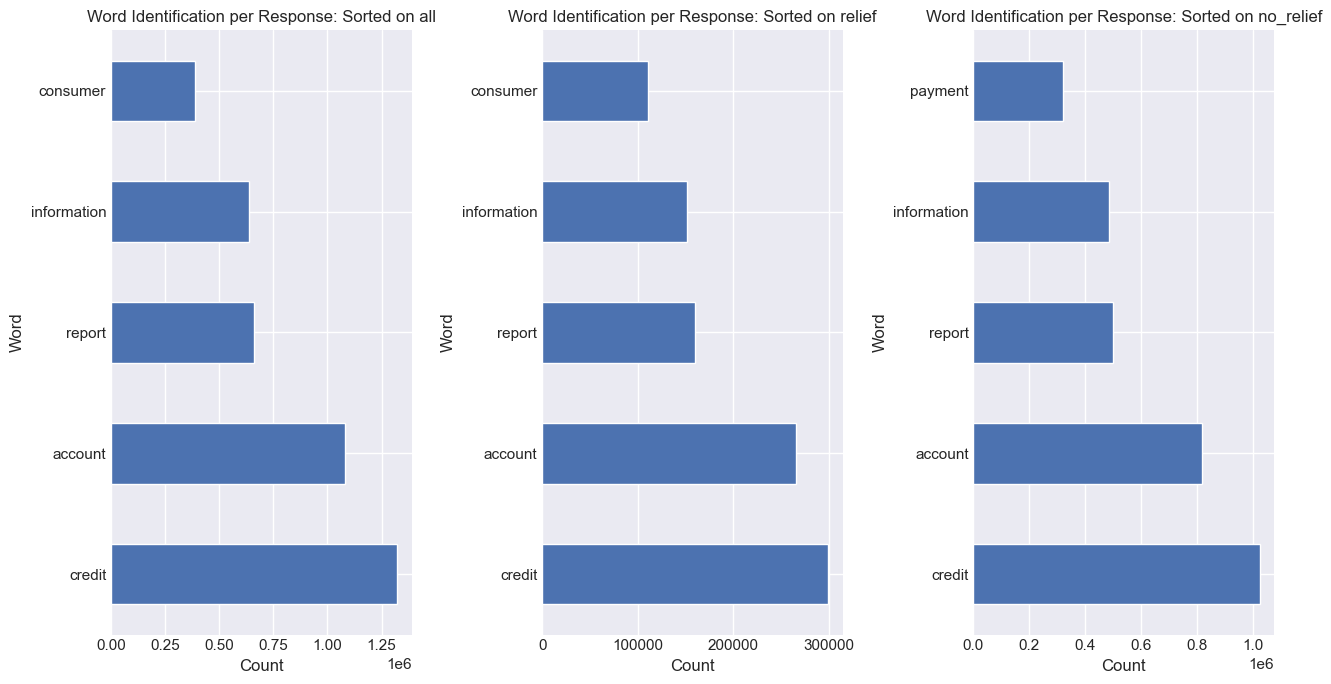

In [8]:
# Visualize words per company response
ex.unique_words(word_counts,1,3)

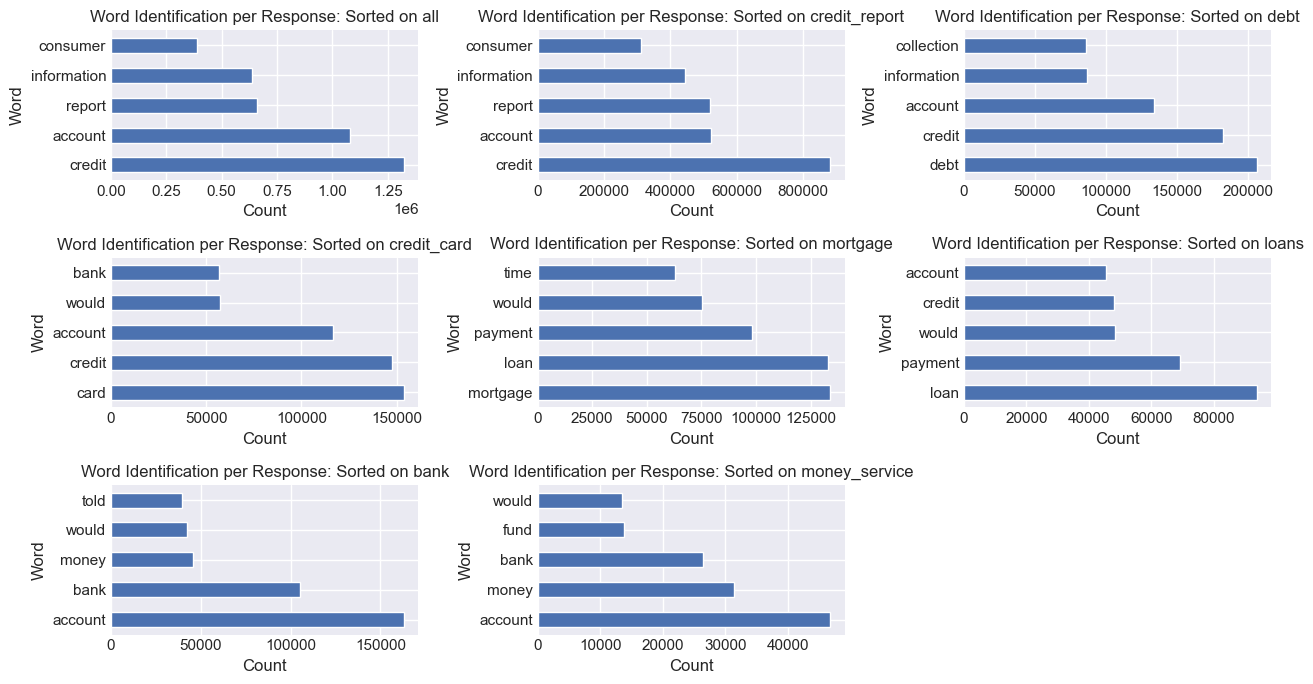

In [9]:
# Visualize words per product
ex.unique_words(word_counts_products,3,3)

<div class="alert alert-success">

## Insight:

There is not a relationship between words used in complaints responses. The words used relate to products that consumer's can complain about. There are unique words associated with each product and those words can be used to predict a response.

### Company Responses and top 5 words:

* Relief
    * Credit, Account, Report, Information, Consumer
* No Relief
    * Credit, Account, Report, Information, Payment

---

### Products and top 5 words:
* Credit Report
    * Credit, Account, Report, Information, Consumer
        * matches top words of relief response
* Debt
    * **Debt**, Credit, Account, Information, **Collection**
        * matches some of the top response words but also has its own unique words "debt" and "collection"
* Credit Card
    * **Card**, Credit, Account, Would, Bank
        * matches some of the top response words but also has its own unique word "card"
* Mortgage
    * **Mortgage**, Loan, Payment, Would, **Time**
        * matches some of the other top product words but also has its own unique words "mortgage" and "time"
* Loans
    * Loan, Payment, Would, Credit, Account
        * matches some of the top response words and some top product words
* Bank
    * Account, Bank, Money, Would, **Told**
        * matches some of the top response words and some top product words but also having its own unique word "told"
* Money Service
    * Account, Money, Bank, **Fund**, Would
        * matches some of the top product words but also having its own unique word "fund"


</div>

### <span style="color:lightblue">**4. Which product is more likely to have relief?**</span>

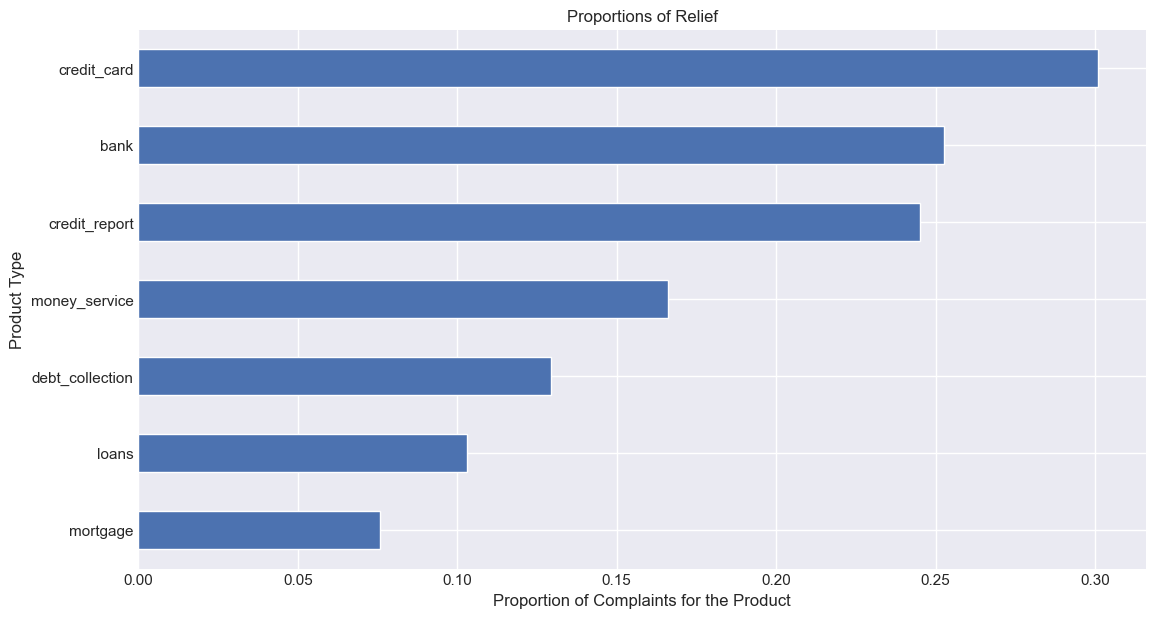

In [10]:
#visualize products and their proportions of relief
ex.relief_product2(train)

<div class="alert alert-success">    

### Insight: 

Credit card, bank, and credit report related products have the highest chance of getting relief at about 25-30% of their total complaints. As for mortgage products, we can see that they have the least chance of getting relief.
</div>

<div class="alert alert-success">  

## <span style="color:darkgreen">Exploration Summary:</span>

* The analysis explored whether there are specific words associated with particular responses. However, the results indicate that there are no specific complaint words uniquely associated with a certain type of company response. Consumers tend to use similar language regardless of the response type they receive.
* The analysis also examined whether all responses have a negative sentiment. The findings suggest that the sentiment of consumer complaints does not have a strong correlation with the type of response received from companies across different industry sectors. Each product category has its own distribution of sentiment scores, and there is no consistent pattern indicating a relationship between sentiment and the response type.
* The analysis identified unique words associated with each product category. For example, words like "collection" are specific to debt-related complaints, while "card" is more common in credit card-related complaints. These unique words can potentially be used to predict the type of response a consumer may receive based on the product they are complaining about.
* The analysis also examined the likelihood of different product categories receiving relief from companies. Credit card, bank, and credit report-related products have a higher chance of receiving relief, while mortgage products have the least chance of receiving relief.

# <span style="color:green">Modeling</span>

---

<div class="alert alert-success">  

### <span style="color:darkslategray">Data Sample:</span>
- Calculated the sample size for each class category using a 20% sampling rate.

- Created smaller datasets by sampling the specified number of samples from each class category.

### <span style="color:darkslategray">Term Frequencies used</span>
- TF-IDF w/ monograms, bigrams, and trigrams

### <span style="color:darkslategray">Selected Classification Models:</span>
- Decision Tree
- Linear Support Vector Classification
- Multi-Layer Perceptron

### <span style="color:darkslategray">Evaluation Metrics:</span>
- Recall
- Accuracy
    * **<span style="color:blue">Baseline: 79.31%</span>**

### <span style="color:darkslategray">Features Sent In:</span>
- Top 2,900 words in 'lemon' column
- Encoded features
    - tags
    - product_bins

### <span style="color:darkslategray">Data Sample:</span>
- Calculated the sample size for each class category using a 20% sampling rate.

- Created smaller datasets by sampling the specified number of samples from each class category.


</div>

In [11]:
# Split into samples/ Split in x and y variables
X_train, y_train, X_val, y_val, X_test, y_test = mo.process_data_modeling2(train, validate, test)

In [12]:
#TD-IDF
#merge with encoded df
X_train_tfe, X_val_tfe, X_test_tfe = mo.process_vector_merge(X_train,X_val,X_test) 

In [13]:
#baseline visualization
mo.baseline(y_train)

Baseline Accuracy: 79.31%


In [14]:
# Model 1: Linear SVC  avg runtime 15 sec
# 2900 mono, bi, & trigrams TDF-IDF + encoded features
mo.svc_multigram_model(X_train_tfe,y_train,X_val_tfe,y_val)

Linear SVC Unigrams, Bigrams, Trigrams
Train Accuracy:      79.53%
Validation Accuracy: 79.46%
Train Recall:        99.22%
Validation Recall:   99.16%


In [15]:
# Model 2: Multi-layer Perceptron    avg runtime 4 min
# 2900 mono, bi, & trigrams TDF-IDF + encoded features
mo.mlp_multigram_model(X_train_tfe,y_train,X_val_tfe,y_val)

Multi-Layer Perceptron Unigrams, Bigrams, Trigrams
Train Accuracy:      80.05%
Validation Accuracy: 79.59%
Train Recall:        98.36%
Validation Recall:   98.13%


In [16]:
# Model 3: Decision Tree    avg runtime 10 sec
# 2900 mono, bi, & trigrams TDF-IDF + encoded features
mo.tree_multigram_model2(X_train_tfe,y_train,X_val_tfe,y_val)

Decision Tree Unigrams, Bigrams, Trigrams
Train Accuracy:      79.55%
Validation Accuracy: 79.42%
Train Recall:        99.41%
Validation Recall:   99.39%


### <span style="color:lightblue">Test Data Run:<span>

In [17]:
# running best model on test data   avg runtime 10 sec
mo.test_svc(X_train_tfe,y_train,X_test_tfe,y_test)

Linear SVC Unigrams, Bigrams, Trigrams
Baseline Accuracy: 79.31%
Test Accuracy:     79.43%
Test Recall:     99.22%


<div class="alert alert-success">    

### Insight: 
   - All models did not exceed our expectations.

- The most accurate model on our train and validate data is a Multi-layer Perceptron with the solver set to 'adam' (optimized Stochastic Gradient Descent) and early_stopping set to True, achieving a validate accuracy of 79.59% but a longer runtime
- The best recall model on our train and validate data is a Decision tree with max_depth of 9, min_samples_leaf of 11, and max_features set to 'sqrt' achieving a validate recall score of 99.4%
- However, we believe the Linear Support Vector Classification model is a good median. The validate accuracy score was 79.46% and recall score was 99.23%, also a quick runtime similar to Decision Tree. We decided to run it on the test data, and it gave us an accuracy score of 79.43% and recall score of 99.22%%.
- We plan to experiment with different features, types of n_grams combinations, and metrics to improve our model's prediction percentage.

</div>

<div class="alert alert-success">  

## <span style="color:darkgreen">Modeling Summary:</span>

* We found that a Linear Support Vector Classification model with C set 0.1 and dual set to False performed the best on our train, validate and test data. However, all models fell short of our expectations, prompting us to explore different feature combinations, types of n_grams, and evaluation metrics to enhance our model's prediction accuracy.

</div>

# <span style="color:green">Conclusion</span>

---

<div class="alert alert-warning">  

<div class="alert alert-success"> 


# Project Summary:

* The analysis explored relationships between complaint words and responses, as well as the sentiment's influence on response types. However, no significant correlations were found between specific words and responses, and sentiment did not consistently impact the response type.
* Unique words associated with each product category were identified, offering insights for response prediction. Certain product categories had higher chances of receiving relief responses, while others had lower probabilities.
* Various machine learning models were evaluated, with the Linear Support Vector Classification model performing well with a validation accuracy of 79.46% and recall of 99.23%. However, all models fell short of expectations, prompting further exploration of feature combinations and n-gram types for enhanced prediction accuracy.
</div>

<div class="alert alert-success">    

## Recommendations & Next Steps
* **Enhance Response Analysis**: The project highlights the need to analyze company responses to consumer complaints. Consider investing in natural language processing (NLP) techniques to extract meaningful insights from response data. By understanding the patterns and sentiments in responses, it might be possible to identify areas for improvement and optimize customer interactions.
* **Monitor Sentiment and Product Categories**: Pay attention to sentiment analysis of consumer complaints across different product categories. Identify trends in sentiment and response types to understand customer expectations and tailor the response strategies accordingly. This can help to improve the overall customer experience and target specific pain points in different product categories.
* **Address Discrimination and Bias**: Conduct further analysis on zip codes, states, and company responses to identify potential discrimination or bias in the complaint resolution process. Ensure fairness and equality by addressing any disparities and taking appropriate actions to eliminate discriminatory practices.
* **Identify Industry Trends**: Look for industry-specific trends by analyzing complaints related to specific companies, such as Silicon Valley Bank and Bank of America. This analysis can help identify emerging issues, detect patterns of non-compliance, and proactively address potential risks.
* **Continuous Improvement**: Treat the project as a starting point and continuously refine the complaint resolution processes. Regularly review customer feedback, complaints, and company responses to identify areas for improvement. Implement a feedback loop to integrate customer insights into operations and drive continuous improvement initiatives.

</div>